# Integrating Functional Data

So far most of our work has been examining anatomical images - the reason being is that it provides a nice visual way of exploring the effects of data manipulation and visualization is easy. In practice, you will most likely not analyze anatomical data using <code>nilearn</code> since there are other tools that are better suited for that kind of analysis (freesurfer, connectome-workbench, mindboggle, etc...). 

In this notebook we'll finally start working with functional MR data - the modality of interest in this workshop. First we'll cover some basics about how the data is organized (similar to T1s but slightly more complex), and then how we can integrate our anatomical and functional data together using tools provided by <code>nilearn</code>

Functional data consists of full 3D brain volumes that are *sampled* at multiple time points. Therefore you have a sequence of 3D brain volumes, stepping through sequences is stepping through time and therefore time is our 4th dimension! Here's a visualization to make this concept more clear:

<img src="./static/images/4D_array.png" alt="Drawing" align="middle" width="500px"/>

Each index along the 4th dimensions (called TR for "Repetition Time", or Sample) is a full 3D scan of the brain. Pulling out volumes from 4-dimensional images is similar to that of 3-dimensional images except you're now dealing with:


<code> img.slicer[x,y,z,time] </code>!

Let's try a couple of examples to familiarize ourselves with dealing with 4D images. But first, let's pull some functional data using PyBIDS!

In [1]:
import os
import matplotlib.pyplot as plt #to enable plotting within notebook
from nilearn import image as img
from nilearn import plotting as plot
from bids.layout import BIDSLayout
import numpy as np
%matplotlib inline

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout=BIDSLayout(fmriprep_dir, validate=False)
T1w_files = layout.get(subject='10788', datatype='anat', suffix='preproc')
brainmask_files = layout.get(subject='10788', datatype='anat', suffix='brainmask')
func_files = layout.get(subject='10788', datatype='func', suffix='preproc')
func_mask_files = layout.get(subject='10788', datatype='func', suffix='brainmask')

We'll be using functional files in MNI space rather than T1w space. Recall, that MNI space data is data that was been warped into standard space. These are the files you would typically use for a group-level functional imaging analysis!

In [3]:
func_mni = func_files[1].path
func_mni_img = img.load_img(func_mni)

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/nibabel/nifti1.py:1682: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  magic = np.asscalar(hdr['magic'])


First, take a look at the shape of the functional image:

In [4]:
func_mni_img.shape

(60, 86, 65, 152)

Notice that the Functional MR scan contains *4 dimensions*. This is in the form of $(x,y,z,t)$, where $t$ is time. 
We can use slicer as usual where instead of using 3 dimensions we use 4. 

For example:

<code> func.slicer[x,y,z] </code> 

vs.

<code> func.slicer[x,y,z,t] </code>

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/nibabel/nifti1.py:1682: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  magic = np.asscalar(hdr['magic'])
/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


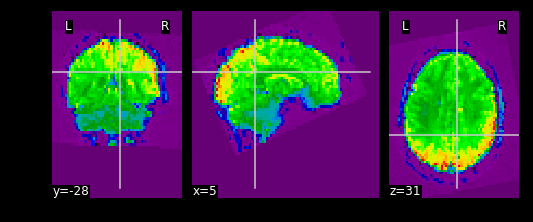

In [5]:
#Pull the 5th TR
func_vol5 = func_mni_img.slicer[:,:,:,4]
plot.plot_epi(func_vol5)

## What fMRI actually represents

We've represented fMRI as a snapshot of MR signal over multiple timepoints. This is a useful way of understanding the organization of fMRI, however it isn't typically how we think about the data when we analyze fMRI data. fMRI is typically thought of as **time-series** data. We can think of each voxel (x,y,z coordinate) as having a time-series of length T. The length T represents the number of volumes/timepoints in the data. Let's pick an example voxel and examine its time-series using <code>func_mni_img.slicer</code>:

In [6]:
func_mni_img.shape

(60, 86, 65, 152)

In [7]:
#Pick orne voxel at coordinate (60,45,88)
single_vox = func_mni_img.slicer[59:60,45:46,30:31,:].get_data()
single_vox.shape

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/nibabel/nifti1.py:1682: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  magic = np.asscalar(hdr['magic'])


(1, 1, 1, 152)

As you can see here, we pulled one voxel that contains 152 timepoints. For plotting purposes as 4-dimensional array is difficult to deal with so we'll flatten it to 1 dimension (time) for convenience:

In [8]:
single_vox = single_vox.flatten()
single_vox.shape

(152,)

Here we've pulled out a voxel at a specific coordinate at every single time-point. This voxel has a single value for each timepoint and therefore is a time-series. We can visualize this time-series signal by using a standard python plotting library. We won't go into too much detail about python plotting, the intuition about what the data looks like is what is most important:

In [9]:
import matplotlib.pyplot as plt

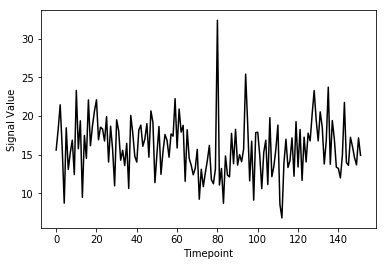

In [10]:
plt.plot(np.arange(0,single_vox.shape[0]),single_vox,'k')
plt.xlabel('Timepoint')
plt.ylabel('Signal Value')

## Resampling
Recall from our introductory exploration of neuroimaging data:

- T1 images are typically composed of voxels that are 1x1x1 in dimension
- Functional images are typically composed of voxels that are 4x4x4 in dimension

If we'd like to overlay our functional on top of our T1 (for visualization purposes, or analyses), then we need to match the size of the voxels! 

Think of this like trying to overlay a 10x10 JPEG and a 20x20 JPEG on top of each other. To get perfect overlay we need to resize (or more accurately *resample*) our JPEGs to match!

**Note**: 
Resampling is a method of interpolating in between data-points. When we stretch an image we need to figure out what goes in the spaces that are created via stretching - resampling does just that. In fact, resizing any type of image is actually just resampling to new dimensions. 

Let's resampling some MRI data using nilearn. 

**Goal**: Match the dimensions of the structural image to that of the functional image

In [11]:
#Files we'll be using (Notice that we're using _space-MNI..._ which means they are normalized brains)
T1_mni = T1w_files[1].path
T1_mni_img = img.load_img(T1_mni)

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/nibabel/nifti1.py:1682: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  magic = np.asscalar(hdr['magic'])


Let's take a look at the sizes of both our functional and structural files:

In [12]:
print(T1_mni_img.shape)
print(func_mni_img.shape)

(193, 229, 193)
(60, 86, 65, 152)


Resampling in nilearn is as easy as telling it which image you want to sample and what the target image is.
Structure of function:

img.resample_to_img(source_img,target_img,interpolation) 
- source_img = the image you want to sample
- target_img = the image you wish to *resample to* 
- interpolation = the method of interpolation

A note on **interpolation**

nilearn supports 3 types of interpolation, the one you'll use depends on the type of data you're resampling!
1. **continuous** - Interpolate but maintain some edge features.  Ideal for structural images where edges are well-defined. Uses $3^\text{rd}$-order spline interpolation.
2. **linear (default)** - Interpolate uses a combination of neighbouring voxels - will blur. Uses trilinear interpolation.
3. **nearest** - matches value of closest voxel (majority vote from neighbours). This is ideal for masks which are binary since it will preserve the 0's and 1's and will not produce in-between values (ex: 0.342). Also ideal for numeric labels where values are 0,1,2,3... (parcellations). Uses nearest-neighbours interpolation with majority vote.


(60, 86, 65)
(60, 86, 65, 152)


/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


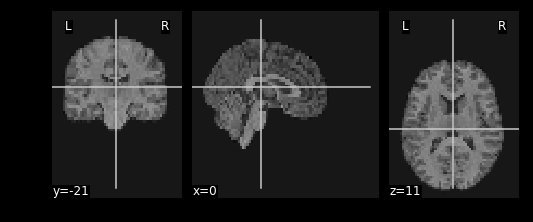

In [14]:
#Try playing around with methods of interpolation
#options: 'linear','continuous','nearest'
resamp_t1 = img.resample_to_img(source_img=T1_mni_img,target_img=func_mni_img,interpolation='continuous')
print(resamp_t1.shape)
print(func_mni_img.shape)
plot.plot_anat(resamp_t1)

In [15]:
import matplotlib.animation
from IPython.display import HTML

In [22]:
%%capture
%matplotlib inline
#Resample the T1 to the size of the functional image!
resamp_t1 = img.resample_to_img(source_img=T1_mni_img, target_img=func_mni_img, interpolation='continuous')
fig, ax = plt.subplots()

def animate(image):
    plot.plot_anat(image, figure=fig, cut_coords=(0,0,0))
    ax.set_facecolor('black')
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=[resamp_t1, T1_mni_img]) 
#change the frames to look at the functional mask over the resampled T1
# ani = matplotlib.animation.FuncAnimation(fig, animate, frames=[resamp_t1, func]) 

In [1]:
# Display animation
HTML(ani.to_jshtml())

NameError: name 'HTML' is not defined

## **Exercise**

Using **Native** T1 and **T1w** resting state functional do the following:
1. Resample the native T1 image to resting state size
2. Replace the brain in the T1 image with the first frame of the resting state brain

In [27]:
func_files[0]

<BIDSImageFile filename='/mnt/tigrlab/projects/jjeyachandra/scwg2018_python_neuroimaging/data/ds000030/derivatives/fmriprep/sub-10171/func/sub-10171_task-rest_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'>

In [28]:
func_mask_files

[<BIDSImageFile filename='/mnt/tigrlab/projects/jjeyachandra/scwg2018_python_neuroimaging/data/ds000030/derivatives/fmriprep/sub-10171/func/sub-10171_task-rest_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz'>,
 <BIDSImageFile filename='/mnt/tigrlab/projects/jjeyachandra/scwg2018_python_neuroimaging/data/ds000030/derivatives/fmriprep/sub-10171/func/sub-10171_task-rest_bold_space-T1w_brainmask.nii.gz'>]

In [36]:
#Files we'll need


####STRUCTURAL FILES

#T1 image
ex_t1 = img.load_img(T1w_files[0].path)

#mask file
ex_t1_bm = img.load_img(brainmask_files[0].path)


####FUNCTIONAL FILES

#This is the pre-processed resting state data that hasn't been standardized
ex_func = img.load_img(func_files[1].path)

#This is the associated mask for the resting state image.
ex_func_bm = img.load_img(func_mask_files[1].path)

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/nibabel/nifti1.py:1682: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  magic = np.asscalar(hdr['magic'])


The first step we need to do is to make sure the dimensions for our T1 image and resting state image match each other:

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


(60, 86, 65)


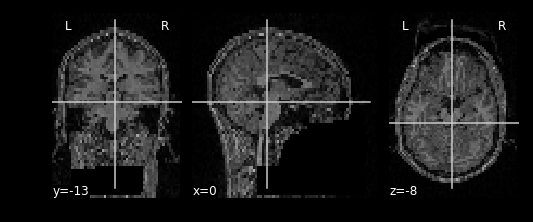

In [40]:
#Resample the T1 to the size of the functional image!
resamp_t1 = img.resample_to_img(source_img=ex_t1, target_img=ex_func, interpolation='continuous')
plot.plot_anat(resamp_t1)
print(resamp_t1.shape)

Next we want to make sure that the brain mask for the T1 is also the same dimensions as the functional image. This is exactly the same as above, except we use the brain mask as the source.

What kind of interpolation should we use for masks? 

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


(60, 86, 65)


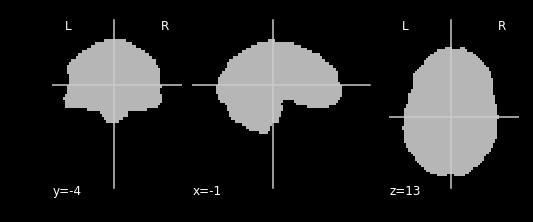

In [41]:
resamp_bm = img.resample_to_img(source_img=ex_t1_bm, target_img=ex_func,interpolation='nearest')
plot.plot_anat(resamp_bm)
print(resamp_bm.shape)

Once we've resampled both our T1 and our brain mask. We now want to remove the brain from the T1 image so that we can replace it with the funtional image instead. Remember to do this we need to:

1. Invert the T1 mask
2. Apply the inverted mask to the brain

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


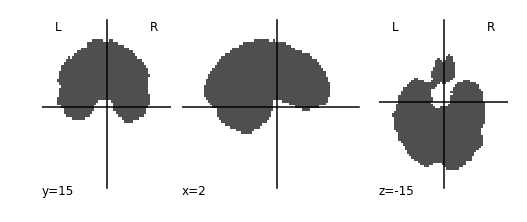

In [46]:
inverted_bm_t1 = img.math_img('1-a',a=resamp_bm)
plot.plot_anat(inverted_bm_t1)

Now apply the mask:

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


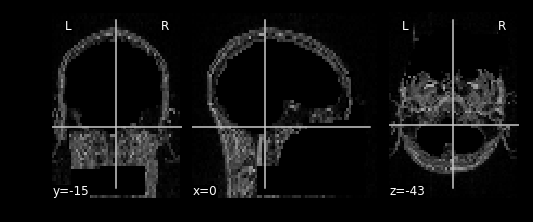

In [47]:
resamp_t1_nobrain = img.math_img('a*b',a=resamp_t1,b=inverted_bm_t1)
plot.plot_anat(resamp_t1_nobrain)

We now have a skull missing the structural T1 brain. The final steps is to stick in the brain from the functional image into the now brainless head. First we need to remove the surrounding signal from the functional image.

Since a functional image is 4-Dimensional, we'll need to pull the first volume to work with. This is because the structural image is 3-dimensional and operations will fail if we try to mix 3D and 4D data.

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/nibabel/nifti1.py:1682: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  magic = np.asscalar(hdr['magic'])
/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


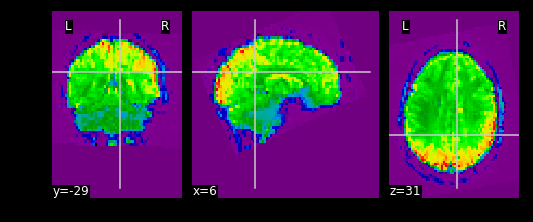

In [42]:
#Let's visualize the first volume of the functional image:
first_vol = ex_func.slicer[:,:,:,0]
plot.plot_epi(first_vol)

As shown in the figure above, the image has some "signal" outside of the brain. In order to place this within the now brainless head we made earlier, we need to mask out the functional MR data as well!

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


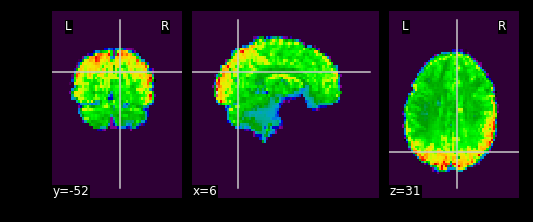

In [43]:
masked_func = img.math_img('a*b', a=first_vol, b=ex_func_bm)
plot.plot_epi(masked_func)

The final step is to stick this data into the head of the T1 data. Since the hole in the T1 data is represented as $0$'s. We can add the two images together to place the functional data into the void:

/projects/jjeyachandra/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.6/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


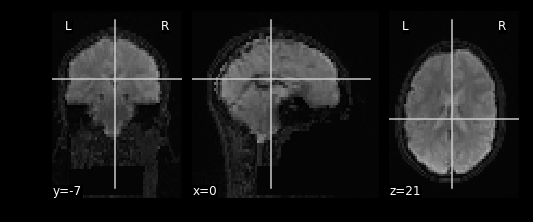

In [48]:
#Now overlay the functional image on top of the anatomical
combined_img = img.math_img('a+b',a=resamp_t1_nobrain,b=masked_func)
plot.plot_anat(combined_img)

***

In this section we explored functional MR imaging. Specifically we covered:
    
1. How the data in a fMRI scan is organized - with the additional dimension of timepoints
2. How we can integrate functional MR images to our structural image using resampling
3. How we can just as easily manipulate functional images using <code>nilearn</code>

Now that we've covered all the basics, it's time to start working on data processing using the tools that we've picked up. 